In [1]:
import os
import glob
from dotenv import load_dotenv

load_dotenv()

MODEL = "llama3"

In [51]:
from langchain_community.llms import Ollama
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
from operator import itemgetter

# TODO: Using Memory search for now. Good idea to switch to vector database in future
from langchain_community.vectorstores import DocArrayInMemorySearch, Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.embeddings import OllamaEmbeddings
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from PyPDF2 import PdfReader

import uuid
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryByteStore
from langchain_core.documents import Document
from langchain.document_loaders import DirectoryLoader, TextLoader

from tqdm import tqdm


In [25]:
model = Ollama(model=MODEL)
ollama_embeddings = OllamaEmbeddings(model=MODEL)
parser = StrOutputParser()

# Langsmith

In [9]:
# from langsmith import Client
# os.environ['LANGCHAIN_TRACING_V2'] = 'true' # enables tracing 
# os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGSMITH_API_KEY")
# os.environ['LANGCHAIN_PROJECT'] = 'Test'
# client = Client()

In [10]:
# model.invoke(f"hello world")
# https://smith.langchain.com/o/a2673a5a-673b-57f0-a982-89ff7985f78f/projects/p/65623a8d-8bd5-40f6-9278-25a5bf53a021?timeModel=%7B%22duration%22%3A%227d%22%7D

# Loading Files to create vectorstore

In [65]:
pdf_loader = DirectoryLoader("../data/", glob="*/*.pdf", loader_cls=PyPDFLoader,silent_errors=True)
pdf_documents = pdf_loader.load()
txt_loader = DirectoryLoader("../data/", glob="*/*.txt", loader_cls=TextLoader,silent_errors=True)
txt_documents = txt_loader.load()
# tl = TextLoader("..\data\test\HPP Mega Set Combined via Jacob Cole and RPC.txt",encoding='UTF-8')

invalid pdf header: b'<?xml'
EOF marker not found
Error loading file ..\data\HPP Papers (PDF) Via Liezl Puzon\10.1136___bcr-2019-233350.pdf: Stream has ended unexpectedly
invalid pdf header: b'<html'
EOF marker not found
Error loading file ..\data\HPP Papers (PDF) Via Liezl Puzon\10.1136___pgmj.53.618.204.pdf: Stream has ended unexpectedly
invalid pdf header: b'<html'
EOF marker not found
Error loading file ..\data\HPP Papers (PDF) Via Liezl Puzon\10.1136___pgmj.53.622.480.pdf: Stream has ended unexpectedly
Error loading file ..\data\HPP Papers (PDF) Via Liezl Puzon\10.1507___endocrj.ej20-0203.pdf: cryptography>=3.1 is required for AES algorithm
Advanced encoding /90ms-RKSJ-H not implemented yet
Advanced encoding /90ms-RKSJ-V not implemented yet
Advanced encoding /90ms-RKSJ-H not implemented yet
Advanced encoding /90ms-RKSJ-V not implemented yet
Advanced encoding /90ms-RKSJ-H not implemented yet
Advanced encoding /90ms-RKSJ-V not implemented yet
Advanced encoding /90ms-RKSJ-H not imple

In [61]:
def get_paths(directory, extension):
  """  This function recursively searches a directory and its subdirectories for PDF files and returns a list of their full paths."""
  paths = []
  for root, _, files in os.walk(directory):
    for filename in files:
      if filename.lower().endswith(extension):  # Ensure case-insensitive matching
        paths.append(os.path.join(root, filename))
  return paths
pdf_paths = get_paths("../data/", ".pdf")
txt_paths = get_paths("../data/", ".txt")

In [87]:
import PyPDF2

def reset_eof_of_pdf_return_stream(pdf_stream_in: list) -> list:
    # Find the line position of the EOF marker
    actual_line = None
    for i, x in enumerate(pdf_stream_in[::-1]):
        if b'%%EOF' in x:
            actual_line = len(pdf_stream_in) - i
            # print(f'EOF found at line position {-i} = actual {actual_line}, with value {x}')
            break

    # If the EOF marker was found, return the list up to that point
    if actual_line is not None:
        return pdf_stream_in[:actual_line]
    else:
        raise ValueError("EOF marker not found in the PDF stream")

# Function to clean the PDF file
def clean_pdf_file(input_file_path: str, output_file_path: str):
    # Open the original PDF file for reading
    with open(input_file_path, 'rb') as input_file:
        pdf_lines = input_file.readlines()

    # Get the new list terminating correctly
    cleaned_pdf_lines = reset_eof_of_pdf_return_stream(pdf_lines)

    # Write the cleaned content to a new PDF file
    with open(output_file_path, 'wb') as output_file:
        output_file.writelines(cleaned_pdf_lines)


In [88]:
docs_all = []
for p in pdf_paths:
    new_path = os.path.join("../data/HPP Papers (PDF) Via Liezl Puzon_cleaned", os.path.basename(p))
    clean_pdf_file(p, new_path)

ValueError: EOF marker not found in the PDF stream

In [86]:
def create_and_save_vector_store(docs, persist_directory):
    vectordb = Chroma.from_documents(docs, ollama_embeddings, persist_directory=persist_directory)
    # Persist the database to disk
    vectordb.persist()
    return vectordb
persist_directory = "../chromadb"
def load_persisted_db(persist_directory):
    vectordb = Chroma(persist_directory=persist_directory)
    return vectordb
vectorstore = load_persisted_db(persist_directory) # vectordb.get() is empty if just initialized --  {'ids': [], 'embeddings': None, 'metadatas': [], 'documents': [], 'uris': None, 'data': None}


In [69]:
# docs = [*pdf_documents, *txt_documents]
# persist_directory = "../chromadb"
# create_and_save_vector_store(docs, persist_directory)

In [9]:
f = r"C:\Users\TechD\Documents\Marcus\LLMs\Rarediseases2024\data\HPP Papers (PDF) Via Liezl Puzon\10.1002___ajmg.a.33146.pdf"
loader = PyPDFLoader(f)
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)
all_text = ""
for doc in docs:
    all_text += doc.page_content  # Concatenate text content from each page
chunks = text_splitter.split_text(all_text)

# docs_ = []
# docs_.extend([*docs])
# doc_text = [d.page_content for d in docs_]

persist_directory = "../chromadb_all"
create_and_save_vector_store(chunks,persist_directory)

In [ ]:
def is_valid_pdf(file_path):
    try:
        reader = PdfReader(file_path)
        reader.pages[0]  # Try accessing the first page
        return True
    except Exception:
        return False

def load_pdf(file_path):
    loader = PyPDFLoader(file_path)
    return loader.load()

def process_pdfs(pdf_paths):
    all_chunks = []
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)
    for path in pdf_paths:
        if is_valid_pdf(path):
            documents = load_pdf(path)
            chunks = text_splitter.split_text(documents)
            all_chunks.extend(chunks)
        else:
            print(f"Invalid PDF file: {path}")
    return all_chunks
def get_pdf_paths(directory):
  """  This function recursively searches a directory and its subdirectories for PDF files and returns a list of their full paths."""
  pdf_paths = []
  for root, _, files in os.walk(directory):
    for filename in files:
      if filename.lower().endswith(".pdf"):  # Ensure case-insensitive matching
        pdf_paths.append(os.path.join(root, filename))
  return pdf_paths

In [36]:
# # Directory containing PDFs
# pdf_directory = r"C:\Users\TechD\Documents\Marcus\LLMs\Rarediseases2024\data"
# pdf_paths = get_pdf_paths(pdf_directory)
# pdf_chunks = process_pdfs(pdf_paths[:1])

In [ ]:
def load_multiple_pdfs(pdf_paths):
  """
  Loads multiple PDF files into LangChain for question answering.
  Args:
      pdf_paths (list): A list of full paths to the PDF files.
  Returns:
      langchain.RetrievalQA: A LangChain model for retrieving information
          from the loaded PDFs.
  """

  documents = []
  embeddings = []

  # Load each PDF and extract text
  for path in pdf_paths:
    loader = PyPDFLoader(path)
    pages = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)

    # for page in pages:
    text = text_splitter.split_documents(pages)  # Split page text
    documents.append(text)  # Store document text
  return documents

  # Create embeddings (replace with your preferred method)
  ollama_embeddings = OllamaEmbeddings(model=MODEL)
  vectorstore = DocArrayInMemorySearch.from_documents(pages, embedding=ollama_embeddings)
  return vectorstore
# vectorstore = load_multiple_pdfs(pdfs) # TODO: embeddings and model as parameters
# # vectorstore = DocArrayInMemorySearch.from_documents(pages, embedding=embeddings)

# Summaries

In [10]:
summary_chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | model
    | StrOutputParser()
)

summaries = summary_chain.batch(docs, {"max_concurrency": 5}) # uncomment [:2]

In [6]:
# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# Add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

NameError: name 'summaries' is not defined

{'ids': [],
 'embeddings': None,
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None}

# Using pinecone

In [ ]:
# # pinecone trial
# f = r"C:\Users\TechD\Documents\Marcus\LLMs\Rarediseases2024\data\HPP Papers (PDF) Via Liezl Puzon\10.1002___ajmg.a.33146.pdf"
# loader = PyPDFLoader(f)
# docs = loader.load()
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)
# all_text = ""
# for doc in docs:
#     all_text += doc.page_content  # Concatenate text content from each page
# chunks = text_splitter.split_text(all_text)

In [33]:
# import logging
# import sys
# import os
# from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
# from llama_index.vector_stores.pinecone import PineconeVectorStore
# from llama_index.core import StorageContext

# logging.basicConfig(stream=sys.stdout, level=logging.INFO)
# logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

# from pinecone import Pinecone, ServerlessSpec
# pc_api_key = os.getenv("PINECONE_API_KEY")
# pc = Pinecone(api_key=pc_api_key)
# pc.create_index(
#     name="rarediseases2024",
#     dimension=4096,
#     metric="cosine",
#     spec=ServerlessSpec(cloud="aws", region="us-east-1"),
# )

In [ ]:

retriever = vectorstore.as_retriever()# Using pinecone

# Trying RAPTOR but it takes too long to load
https://github.com/langchain-ai/langchain/blob/master/cookbook/RAPTOR.ipynb

In [ ]:
import matplotlib.pyplot as plt

def num_tokens_from_string(model, string: str) -> int:
    """Returns the number of tokens in a text string."""
    return model.get_num_tokens(string)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Token indices sequence length is longer than the specified maximum sequence length for this model (1067 > 1024). Running this sequence through the model will result in indexing errors


<function matplotlib.pyplot.show(close=None, block=None)>

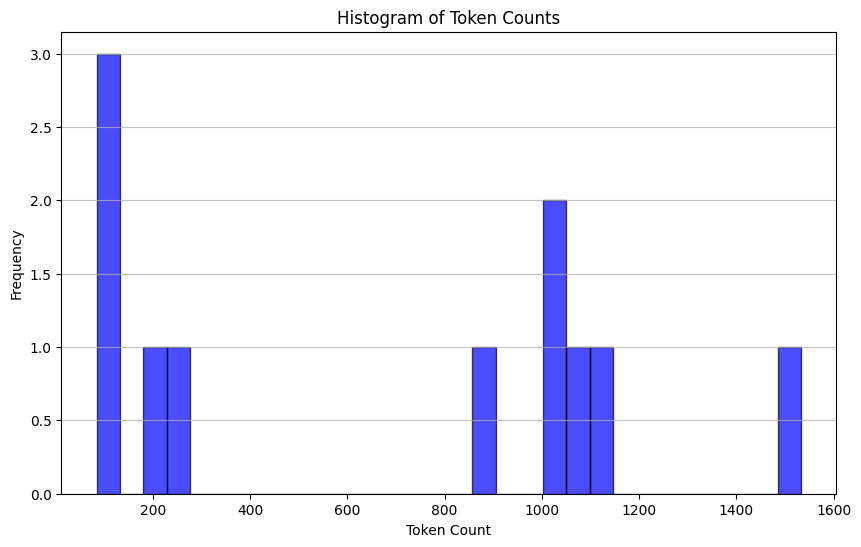

In [ ]:
counts = [num_tokens_from_string(model, d) for d in doc_text]
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show

In [ ]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224  # Fixed seed for reproducibility

### --- Code from citations referenced above (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###

embd = ollama_embeddings
def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a sub-set of LangChain Expression Language doc. 
    
    LangChain Expression Language provides a way to compose chain in LangChain.
    
    Give a detailed summary of the documentation provided.
    
    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

c:\Users\TechD\Documents\Marcus\LLMs\Rarediseases2024\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
# leaf_texts = doc_text[:2]
# results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

# Creating Prompts and Chain

In [ ]:
# Input template
template = """Answer the question based on the context below. If you can't answer the question, reply "I don't know".
Context: {context}
Question: {question}"""
prompt = PromptTemplate.from_template(template = template)
prompt.format(context="Here is some context", question="Here is a question")

# Generate perspectives from question
prompt_perspectives_template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = PromptTemplate.from_template(template = prompt_perspectives_template)



In [ ]:
generate_queries = (
    prompt_perspectives 
    | model
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [ ]:
# dependencies for multiquery
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

In [ ]:
# Retrieve
question = "What is HPP?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})

In [ ]:
final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
questions = [
    # Input questions
    "What is HPP?",
    "Can you give me a summary of HPP?"
]

for question in questions:
    print(f"Question: {question}")
    print(f"Answer: {final_rag_chain.invoke({'question':question})}")